<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Machine%20Learning%20Methods/ML_Champagne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pip install -U scikit-learn

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2022-02-16 07:22:33--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: ‘perrin-freres-monthly-champagne.csv’

perrin-freres-month 100%[===================>]   1.56K  --.-KB/s    in 0s      

2022-02-16 07:22:33 (41.6 MB/s) - ‘perrin-freres-monthly-champagne.csv’ saved [1598/1598]



In [5]:
df = pd.read_csv(
    'perrin-freres-monthly-champagne.csv',
    index_col='Month',
    skipfooter=2,
    parse_dates=True
)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
df.columns = ['Sales']

In [7]:
df['LogSales'] = np.log(df['Sales'])

In [8]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [10]:
series = df['LogSales'].to_numpy()
series

array([7.94271754, 7.89058253, 7.92117272, 7.90875474, 7.9882036 ,
       8.01829614, 7.73280753, 7.70165236, 7.98002359, 8.36660283,
       8.65938696, 8.89727211, 7.84031298, 7.81399568, 8.01664788,
       8.09132127, 8.23642053, 8.08023742, 8.01565761, 7.47250074,
       8.18729927, 8.40603814, 8.83025057, 9.03085479, 8.04334217,
       8.00836557, 8.30573114, 8.16706818, 8.27817429, 8.2905435 ,
       8.08948247, 7.3607399 , 8.16848642, 8.55852705, 8.93774394,
       9.13281117, 8.58951385, 8.03527891, 8.22094117, 8.41493896,
       8.41626727, 8.420462  , 8.20603776, 7.40427912, 8.46358142,
       8.59932602, 9.02569612, 9.27340906, 8.19781403, 8.3645081 ,
       8.331827  , 8.32385113, 8.44397713, 8.46653128, 8.28526113,
       7.45182224, 8.5267474 , 8.84246002, 9.19603859, 9.33529761,
       8.29804166, 8.28324144, 8.41405243, 8.36077327, 8.51077262,
       8.45041216, 8.16706818, 7.50714108, 8.56063575, 8.83521046,
       9.28757915, 9.54079454, 7.87815534, 7.97212113, 8.12266

In [11]:
T = 12
x = []
y = []
for t in range(len(series) - T):
  X = series[t:t+T]
  x.append(X)
  Y = series[t+T]
  y.append(Y)

x = np.array(x).reshape(-1, T)
y = np.array(y)
N = len(x)
print('x.shape', x.shape, "y.shape", y.shape)

x.shape (93, 12) y.shape (93,)


In [12]:
xtrain, ytrain = x[:-Ntest], y[:-Ntest]
xtest, ytest = x[-Ntest:], y[-Ntest:]

In [15]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)
print('R2-Score for LinearRegression Training):', lr.score(xtrain, ytrain))

R2-Score for LinearRegression Training): 0.8682372095558999


In [16]:
print('R2-Score for LinearRegression Testing):', lr.score(xtest, ytest))

R2-Score for LinearRegression Testing): 0.9657520752272788


In [17]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # first T values are not predictable

In [18]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(xtest)

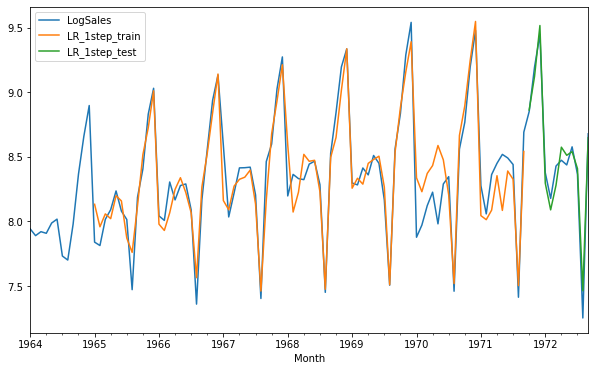

In [20]:
# plot 1-step forecast
df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(10, 6));

Looks pretty good, but remember, this is only the one step forecast

In [21]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [22]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

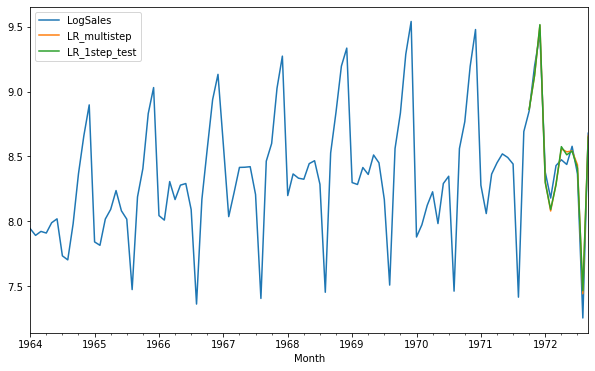

In [23]:
df[['LogSales', 'LR_multistep', 'LR_1step_test']].plot(figsize=(10, 6))

Performed pretty well, in fact, maybe even a bit better than the one step forecast.

In [24]:
# Make multi-output supervised dataset
Tx = T
Ty = Ntest
x = []
y = []
for t in range(len(series) - Tx - Ty + 1):
  X = series[t:t+Tx]
  x.append(X)
  Y = series[t+Tx:t+Tx+Ty]
  y.append(Y)

x = np.array(x).reshape(-1, Tx)
y = np.array(y).reshape(-1, Ty)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (82, 12) y.shape (82, 12)


In [25]:
xtrain_m, ytrain_m = x[:-1], y[:-1]
xtest_m, ytest_m = x[-1:], y[-1:]

In [26]:
lr = LinearRegression()
lr.fit(xtrain_m, ytrain_m)
lr.score(xtrain_m, ytrain_m)

0.8829262390390559

In [28]:
r2_score(lr.predict(xtest_m).flatten(), ytest_m.flatten())

0.9595107879158425

In [29]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(xtest_m).flatten()

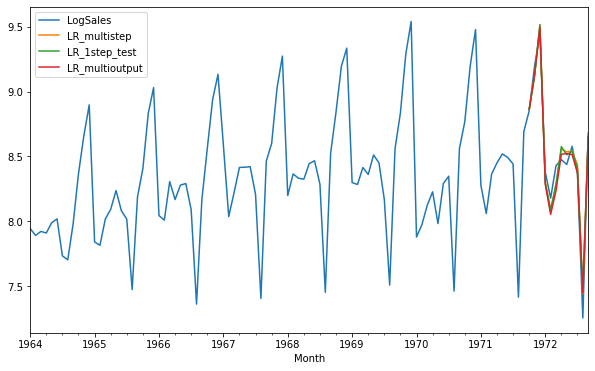

In [30]:
# plot all forecast
cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(10, 6))

In [31]:
# MAPE
mape1 = mean_absolute_percentage_error(ytest, multistep_predictions)
print('multi-step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(
    ytest, df.loc[test_idx, 'LR_multioutput']
)
print('multi-output MAPE:', mape2)

multi-step MAPE: 0.00960716937379777
multi-output MAPE: 0.009727020853255877


# TEST OTHER MODELS

In [34]:
def one_step_and_multistep_forecast(model, name):
  model.fit(xtrain, ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(ytest, multistep_predictions)
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogSales',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.013188370472848127


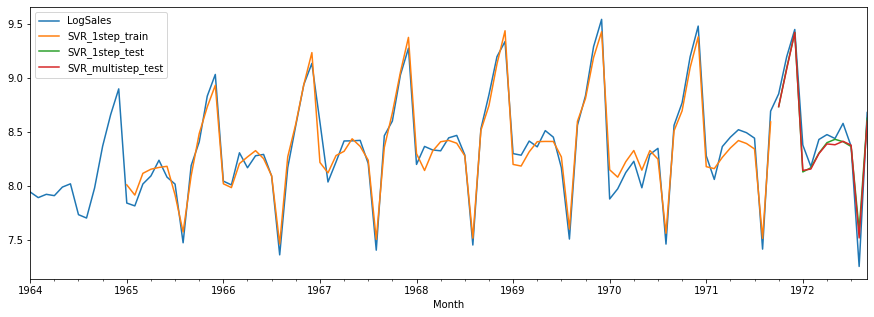

In [35]:
one_step_and_multistep_forecast(SVR(), 'SVR')

One-step forecast: RF
Test MAPE (multi-step): 0.010087062845141478


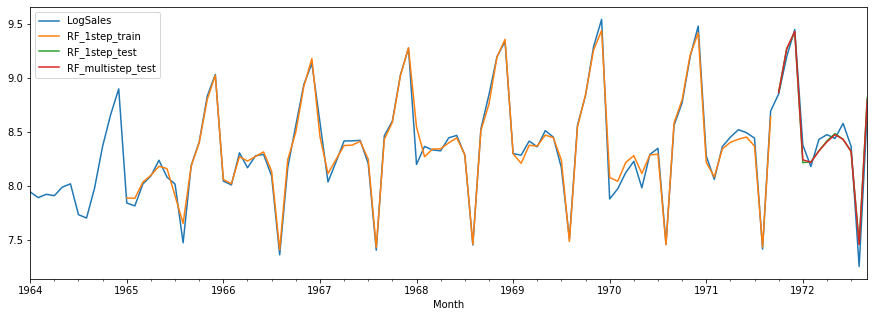

In [36]:
one_step_and_multistep_forecast(RandomForestRegressor(), 'RF')

In [37]:
def multi_output_forecast(model, name):
  model.fit(xtrain_m, ytrain_m)

  # save multioutput forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(xtest_m).flatten()

  mape = mean_absolute_percentage_error(
      ytest, df.loc[test_idx, f'{name}_multioutput']
  )
  print('Test MAPE (multioutput):', mape)
  # plot all forecast
  # assume that previous function have been run
  cols = [
          'LogSales',
          f'{name}_1step_train',
          f'{name}_1step_test',
          f'{name}_multistep_test',
          f'{name}_multioutput',
  ]

  df[cols].plot(figsize=(10, 6))

Test MAPE (multioutput): 0.020473223396409702


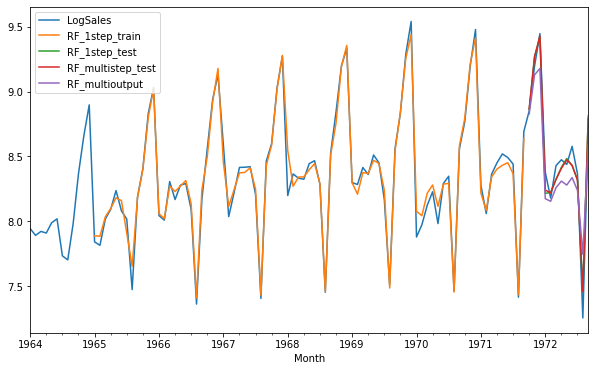

In [38]:
multi_output_forecast(RandomForestRegressor(), 'RF')